In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from ldg.pickle import pickle_read
import pandas as pd
import re

In [14]:
import os
from bssp.common import paths

K = 50
K_RANGE = range(5,55,5)

def read_score(min_train_freq, max_train_freq, min_rarity, max_rarity, eval, metric='cosine', model='bert-base-cased', query_n=1):
    filepath = paths.bucketed_metric_at_k_path(
        distance_metric=metric,
        query_n=query_n,
        embedding_name=model,
        min_train_freq=min_train_freq,
        max_train_freq=max_train_freq,
        min_rarity=min_rarity,
        max_rarity=max_rarity,
        ext=eval
    )
    if not os.path.isfile(filepath):
        print("WARNING: not found: ", filepath)
        return None
    return pickle_read(filepath)

def read_data(metric, model='bert-base-cased', query_n=1):
    filepath = paths.predictions_tsv_path(metric, embedding_name=model, query_n=query_n)
    data = pd.read_csv(filepath, sep='\t')
    return data

cosine_data = read_data('cosine')
cosine_data.keys()

['ontonotes_baseline_q1_predictions', 'ontonotes_stats', 'ontonotes_cosine_q1_predictions', 'dataset']


Index(['sentence', 'label', 'lemma', 'label_freq_in_train', 'label_1',
       'label_2', 'label_3', 'label_4', 'label_5', 'label_6',
       ...
       'distance_41', 'distance_42', 'distance_43', 'distance_44',
       'distance_45', 'distance_46', 'distance_47', 'distance_48',
       'distance_49', 'distance_50'],
      dtype='object', length=204)

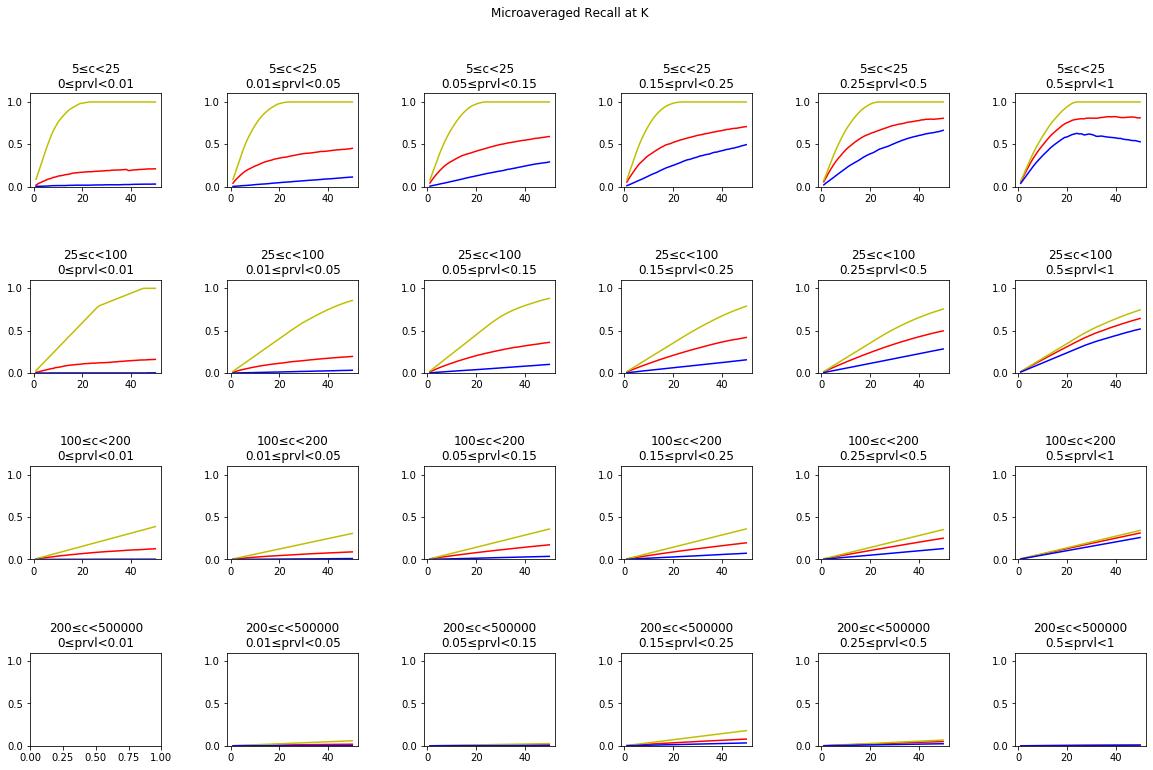

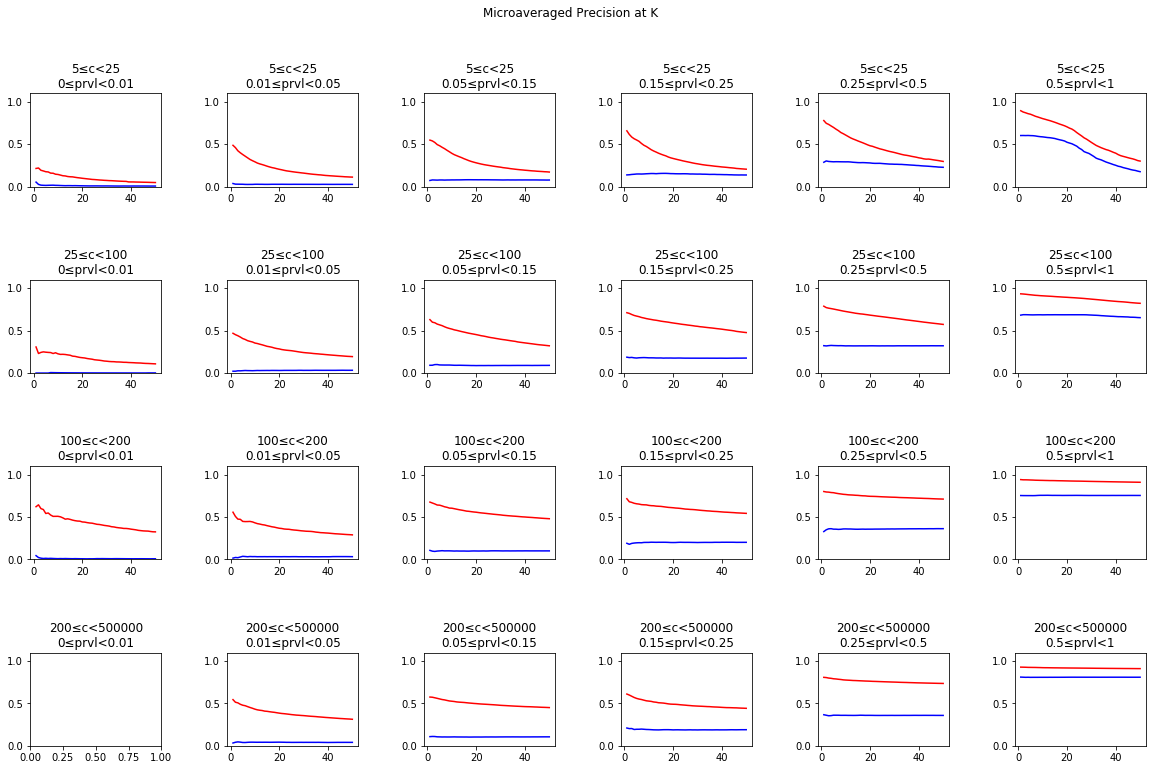

In [15]:
def xyzize(scores_dict, key='synset'):
    x, y, z = [], [], []
    for cutoff, p_at_k_dict in scores_dict.items():
        for k, scores in p_at_k_dict.items():
            if k > cutoff and False:
                continue
            x.append(cutoff)
            y.append(k)
            z.append(scores[key])
    return x, y, z

def plot_surface(scores_dict, key='synset'):
    plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.set_xlabel('occurrence cutoff')
    ax.set_ylabel('k')
    ax.set_zlabel(f'{key} recall')
    #ax.set_zlim(0.3, 1)
    x, y, z = xyzize(scores_dict, key=key)
    ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=0.5)
    plt.show()
    
def plot_p_vs_k(p_at_k_dict, p_at_k_dict_2=None, key='synset'):
    plt.figure(figsize=(7,7))
    ax = plt.axes()
    ax.set_xlabel('k')
    ax.set_ylabel(f'{key} precision')
    ax.set_ylim(0, 1)
    
    k, scores = list(zip(*p_at_k_dict.items()))
    scores = [x[key] for x in scores]
    k = list(k)
    ax.scatter(x=k, y=scores, c=scores)
    if p_at_k_dict_2:
        k, scores = list(zip(*p_at_k_dict_2.items()))
        scores = [x[key] for x in scores]
        k = list(k)       
        ax.scatter(x=k, y=scores, c=scores, marker='x')
    plt.show()    
    
    
def plot_p_vs_k_grid(p_at_k_dict_2=None, key='synset', evals=['rec'], metric='cosine'):
    fig, axs = plt.subplots(4,6,figsize=(20,12))
    plt.subplots_adjust(hspace=1.0, wspace=0.5)
    fig.suptitle("Microaveraged " + ("Recall" if evals[0]=='rec' 
                  else "Oracle Recall" if evals[0]=='orec'
                  else "Truncated Recall" if evals[0]=='trec'
                  else "Precision") + " at K")
    
    i = 0
    for min_train_freq, max_train_freq in [[5,25], [25,100], [100,200], [200, 500000]]:
        for min_rarity, max_rarity in [[0,0.01], [0.01,0.05], [0.05,0.15], [0.15,0.25], [0.25,0.5], [0.5,1]]:
            ax = axs[i//6][i%6]
            i += 1
            ax.set_title(f'{min_train_freq}≤c<{max_train_freq}\n{min_rarity}≤prvl<{max_rarity}')
            #ax.set_ylim(0.2, 0.8)
            ax.set_ylim(0, 1.1)
            
            for metric_ in [metric, 'baseline']: 
                for eval in evals:
                    if eval == 'orec' and metric_ == 'baseline':
                        continue
                    scores = read_score(
                        eval=eval, 
                        min_train_freq=min_train_freq, 
                        max_train_freq=max_train_freq, 
                        min_rarity=min_rarity, 
                        max_rarity=max_rarity,
                        metric=metric_
                    )
                    if scores is None:
                        continue
                    k, scores = list(zip(*scores.items()))
                    scores = [x[key] for x in scores]
                    k = list(k)
                    #ax.scatter(x=k, y=scores, c=scores)
                    ax.plot(k, scores, 
                            'y-' if eval=='orec' else 
                            'b' if metric_ == 'baseline' else 
                            'g' if metric_ == 'rec'
                           else 'r')
                    #ax.scatter(k, scores, 'bo')
    plt.show()
    
#score = read_score(
#    freq_cutoff=5,
#    rarity=5,
#    eval='prec'
#)
#plot_p_vs_k(score, key='synset')
#plot_p_vs_k_grid(key='label', evals=['prec','rec'])
plot_p_vs_k_grid(key='label', evals=['rec', 'orec'])
plot_p_vs_k_grid(key='label', evals=['prec'])
#score

In [4]:
# data columns:
# sentence: original sentence
# label, lemma, synset, label_freq_in_train
# label_i
# synset_i
# lemma_i
# distance_i
list(cosine_data.keys())

def distance_correctness_corr(data, key='label'):
    
    plt.figure(figsize=(8,5))
    ax = plt.axes()
    ax.set_xlabel('k')
    ax.set_ylabel(f'distance correlated with correctness')
    
    df = data.copy()
    for i in range(1,K+1):
        df['correct'] = df[f'{key}_{i}'] == df[f'{key}']
        r = df[['correct', f'distance_{i}']].corr()['correct'][1]
        ax.scatter(i, r, color='blue')
    plt.show()
    

def distance_correctness_histogram(data, key='label'):
    df = data.copy()
    df['first_correct'] = df[f'{key}_1'] == df[f'{key}']
    df[['first_correct', 'distance_1']].pivot(columns='first_correct').distance_1.plot.hist(stacked=True, bins=50)
    plt.show()
    
    
distance_correctness_corr(cosine_data)
#distance_correctness_histogram(euclidean_data[euclidean_data.pos=='r'])
#distance_correctness_histogram(cosine_data)
    

NameError: name 'cosine_data' is not defined

In [ ]:
cosine_scores[5]